# Matcher

In [ ]:
#| default_exp matcher
%load_ext autoreload
%autoreload 2

### Overview
In the previous modules, the LHS Parser received an LHS string, describing some graph pattern, and parsed it to an equivalent NetworkX DiGraph. In the following module, we search for **matches** to this pattern in our input graph - That is, find all subgraphs of our input graph, which have the same structure as the pattern in terms of nodes, the edges connecting them and the attributes they all have. 

Each match is basically a mapping from a subset of the input graph nodes to a the pattern nodes (as we can deduce what are the matched edges and attributes accordingly).

The **Matcher** in this module does the following:
* **Searches for matches** in the input graph, according to some LHS pattern graph.
* **Filters matches** based on an explicit boolean function, and / or constraints given to the matcher by the parser to be handled later.
* **Constructs a list of Match objects**, each corresponds to one of the filtered matches we've found. The list will be used in later modules, and will also allow users to view the matches and to use them imperatively.

The final, filtered list of Match objects is returned from this module's main function, **find_matches**.

### Requirements

In [ ]:
#| export
from typing import *
from networkx import DiGraph
from networkx.algorithms import isomorphism # check subgraph's isom.
import itertools # iterating over all nodes\edges combinations

from graph_rewrite.core import NodeName, _create_graph, _plot_graph
from graph_rewrite.lhs import lhs_to_graph
from graph_rewrite.match_class import Match, mapping_to_match, is_anonymous_node

### Find Matches
Given an input graph and a pattern graph, we want to find the list of matches from pattern nodes to input-graph nodes, each constructs a corresponding Match object. 

#### Checking for Attributes Existance
A significant part of finding matches is comparing the attributes of different nodes to each other, in order to know whether they can match. The Parser, which constructs the pattern graph, does not include explicit required values of attributes in that graph (it stores these value-constraints somewhere else, we'll get to that in a moment).

Therefore, given the pattern graph alone, we can tell whether some pattern node **has** the same attributes (regardless of their values) as some input graph node. This is done by the following function:

In [ ]:
#| export
def _attributes_exist(input_graph_attrs: dict, pattern_attrs: dict) -> bool:
    """Given an input-graph node and a pattern node, checks whether the input-graph node
    has all the attributes which the pattern node requires. If it does, then this input-graph node might be matched as that pattern node.
    
    Note that we only refer to the existence of attributes here, i.e. if both nodes have the same attributes but with
    different values, this function still considers them as a potential pair to match.

    Args:
        input_graph_attrs (dict): Attributes of some input-graph node.
        pattern_attrs (dict): Attributes of some pattern-graph node.

    Returns:
        bool: True if the input-graph node has all the attributes which the pattern node requires, False otherwise.
    """
    return set(pattern_attrs.keys()).issubset(set(input_graph_attrs.keys()))

#### Narrow Down Search Space
Using the functions presented thus far, the search for matches might take a lot of time if the graph has a high number of nodes / edges. Nodes which are no real candidate to match any pattern node (do not share attributes with any pattern node) are checked eitherway, which is extermely inefficient. 

Therefore, before we search for matches in our input graph, we will reduce it to only contain the nodes that might match any of the pattern nodes (and their connected edges as well). This might improve the whole matching performance. The following function is used in order to do exactly that:

In [ ]:
#| export
def _does_node_match_pattern(graph_node_attrs: dict, pattern: DiGraph) -> bool:
    """Given the attributes of some input-graph node, checks whether this node
    has the same attributes as some node in the pattern graph. If it does,
    then the node by match that node in the pattern - and thus, might be included
    in a subgraph that will match the entire pattern.

    Args:
        graph_node_attrs (dict): Attributes of some input-graph node.
        pattern (DiGraph): A pattern graph produced by the LHS Parser.

    Returns:
        bool: True if the input-graph node has the same attributes as some pattern node, False otherwise.
    """
    return any([_attributes_exist(graph_node_attrs, pattern_attr) for (_, pattern_attr) in pattern.nodes(data=True)])

#### Finding Structural Matches
NetworkX provides an out-of-the-box isomorphism matcher, which compares the structure of two graphs and tells whether they are isomorphic (have the same nodes and edges). We utilize this isomorphism matcher by beginning our matching process with structural matches only (completely ignoring the attributes):

In [ ]:
#| export
def _find_structural_matches(graph: DiGraph, pattern: DiGraph) -> Tuple[DiGraph, dict[NodeName, NodeName]]:
    """Given a graph, find all of its subgraphs which have the same structure (same nodes and edges)
    as a given pattern DiGraph. That is, all subgraphs which are isomorphic to the pattern.

    Args:
        graph (DiGraph): A graph to find matches in
        pattern (DiGraph): A pattern graph produced by the LHS Parser.

    Yields:
        Iterator[Tuple[DiGraph, dict[NodeName, NodeName]]]: Iterator of (subgraph, mapping) tuples,
            where for each pair, the subgraph is the subset of nodes and edges in the input graph that
            match the pattern, and the mapping is a dictionary that maps nodes in that subgraph
            to nodes in the pattern.
    """
    for sub_nodes in itertools.combinations(graph.nodes, len(pattern.nodes)):
        nodes_subg: DiGraph = graph.subgraph(sub_nodes)
        for sub_edges in itertools.combinations(nodes_subg.edges(data=True), len(pattern.edges)):
            # Create a subgraph with selected edges and nodes
            subg = DiGraph()
            subg.add_nodes_from(list(nodes_subg.nodes(data=True)))
            subg.add_edges_from(list(sub_edges))

            # Find structural matches with the selected edges and nodes
            matcher = isomorphism.DiGraphMatcher(pattern, subg)
            for isom_mapping in matcher.isomorphisms_iter():
                yield (nodes_subg, isom_mapping)

#### Expanding Matches With Attribtues
Now that we have all structural matches between the graph and the pattern, we want to take our attributes into account.
Currently, we still ignore the values of the attributes, and check whether some structural match also has the attributes of the pattern in the matched subgraph:

In [ ]:
#| export
def _does_isom_match_pattern(isom: Tuple[DiGraph, dict], pattern: DiGraph) -> bool:
    """Given a graph that is isomorphic to the pattern, checks whether they also
    match in terms of their attributes (that is, the graph has the same attributes
    as the pattern). If they does, then the isomorphic graph matches the pattern completely.

    Args:
        isom (Tuple[DiGraph, dict]): A graph that's isomorphic to the pattern
        pattern (DiGraph): A pattern graph produced by the LHS Parser.

    Returns:
        bool: True if the isomorphic graph matches the pattern, False otherwise.
    """

    # check nodes match
    subgraph, mapping = isom
    if not all([_attributes_exist(subgraph.nodes[original_node], pattern.nodes[pattern_node]) \
                for (pattern_node, original_node) in mapping.items()]):
        return False

    # check edges match
    if all([_attributes_exist(subgraph.edges[mapping[edge[0]], mapping[edge[1]]], edge[2]) \
                for edge in pattern.edges(data=True)]):
        return True

#### Filtering Matches
The only thing we ignored up until now is attribute values. As metioned above, the LHS Parser does not include required attribute values in the pattern graph. Instead, it constructs a boolean function which receives a Match object and checks whether the match it represents has the required attribute values (if there are any). 

This boolean function is further extended by the user of the library, which can pass as parameter a function of the same format, which filteres a list of Match objects based on any condition it wishes to apply. The LHS Parser, in addition to the pattern graph, provides the extended filtering function, that mixes both the user and the parser constraints which were not handled by the matcher so far.

Later in this module, we will use the extended function to filter the list of Match objects we get from the structural and attribute-existence-based matchers. The signature of that function will be as follows:

In [ ]:
#| export
FilterFunc = Callable[[Match], bool]

#### Putting It All Togehter
Given our ability to find matches (both structural and in terms of attribute existence) between two graphs, as well as filtering matches according to desired conditions and constraints, we can finally find complete matches of the pattern in our input graph. 

We define one last auxiliary function, which removes duplicated matches based on their mappings:

In [ ]:
#| export
def _remove_duplicated_matches(matches: list[Match]) -> list[Match]:
    """Remove duplicates from a list of Matches, based on their mappings.

    Args:
        matches (list[Match]): list of Match objects

    Returns:
        list[Match]: The list without duplications
    """
    new_list = []
    for match in matches:
        if match not in new_list:
            new_list.append(match)
    return new_list

We are now combining everything we saw in order to find the matches of a pattern in our input graph. The matches are returned as a (filtered) list of Match objects:

In [ ]:
#| export
def find_matches(input_graph: DiGraph, pattern: DiGraph, condition: FilterFunc = lambda match: True) -> List[Match]:
    """Find all matches of a pattern graph in an input graph, for which a certain condition holds.
    That is, subgraphs of the input graph which have the same nodes, edges, attributes and required attribute values
    as the pattern defines, which satisfy any additional condition the user defined.

    Args:
        input_graph (DiGraph): A graph to find matches in
        pattern (DiGraph): A pattern graph produced by the LHS Parser.
        condition (FilterFunc, optional): A function which recives a Match objects, and checks whether some condition holds
            for the corresponding match. Defaults to a condition function which always returns True.

    Returns:
        List[Match]: List of Match objects (without duplications), each corresponds to a match of the pattern in the input graph.
    """

    # Narrow down search space by keeping only input-graph nodes that have the same attributes as some pattern node
    matching_nodes = [n for (n, attrs) in input_graph.nodes(data=True) if _does_node_match_pattern(attrs, pattern)]
    # Reducing the input graph to the matching nodes + connected edges
    reduced_input_g = input_graph.subgraph(matching_nodes)
    
    # Find all structural matches (isomorphisms), ignore attributes
    isom_matches =  [match for match in _find_structural_matches(reduced_input_g, pattern)]
    # Find matches with attributes among isoms (match pattern's attributes)
    attribute_matches = [mapping for (subgraph, mapping) in isom_matches if _does_isom_match_pattern((subgraph, mapping), pattern)]

    # construct a list of Match objects. Note that the condition is checked on a Match that includes anonymous nodes (as it might use it)
    # but the Match that we return does not include the anonymous parts.
    # Therefore, we first construct a list of tuples - the first is the mapping with anonymous, the second isn't
    matches_list = [(mapping_to_match(input_graph, pattern, mapping, filter=False), mapping_to_match(input_graph, pattern, mapping)) 
                    for mapping in attribute_matches]
    # Then filter the list, to contain only the filtered match whose unfiltered version matches the condition
    filtered_matches =  [filtered_match for (unfiltered_match, filtered_match) in matches_list if condition(unfiltered_match)]
    # And finally, remove duplicates (might be created because we removed the anonymous nodes)
    return _remove_duplicated_matches(filtered_matches)

### Tests

#### Test Utils

In [ ]:
def _assert_match(input_graph: DiGraph, LHS: str, expected: list[dict], condition=lambda x: True, plot=True):
    """Match the pattern in the input graph, and validate that the list of matches
    is equal to the expected list of matches. Also allows plotting the first match instance.

    Args:
        input_graph (DiGraph): A graph
        LHS (str): A pattern string
        expected (list[dict]): The list of expected matches (as mappings from pattern nodes to input graph nodes)
        plot (bool, optional): If True, plots the first match instance on the input graph (in red). Defaults to False.
    """
    # Convert the pattern to a NetworkX graph + an extended condition function
    pattern, condition = lhs_to_graph(LHS, condition)
    matches = find_matches(input_graph, pattern, condition=condition)
    assert all([match.mapping in expected for match in matches]) and len(matches) == len(expected)
    if plot and len(matches) > 0:
        mapping = matches[0].mapping
        hl_nodes = {mapping[node] for node in pattern.nodes() if not is_anonymous_node(node)}
        hl_edges = {(mapping[s], mapping[t]) for s, t in pattern.edges() if not (is_anonymous_node(s) or is_anonymous_node(t))}
        print(f"Plotting the match: {mapping}")
        _plot_graph(input_graph, hl_nodes=hl_nodes, hl_edges=hl_edges)

#### Basic Test Cases

We begin with simple cases, which do not take attributes into account at all. Consider the following quite-generic input graph (in which we will try to find matches for different patterns):

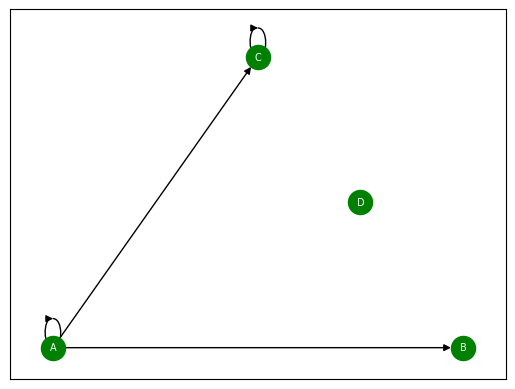

In [ ]:
input_graph = _create_graph(
    ['A','B','C','D'], 
    [
        ('A', 'B'),
        ('A', 'C'),
        ('A', 'A'),
        ('C', 'C'),
    ]
)
_plot_graph(input_graph)

In the following tests, we try to match different patterns and make sure that the matcher found all of the possible matches. The first match in the list will be highlighted in the input graph (nodes and edges are colored in red), and printed above the plot:

Plotting the match: {'1': 'A'}


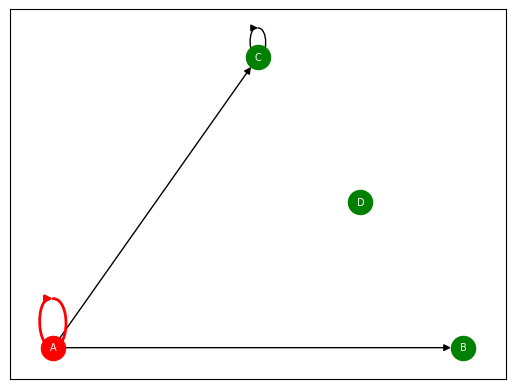

In [ ]:
# Match all nodes 1 with self loops (both A and C)
_assert_match(input_graph, "1->1", [{'1': 'A'}, {'1': 'C'}])

Plotting the match: {'1': 'A', '2': 'B'}


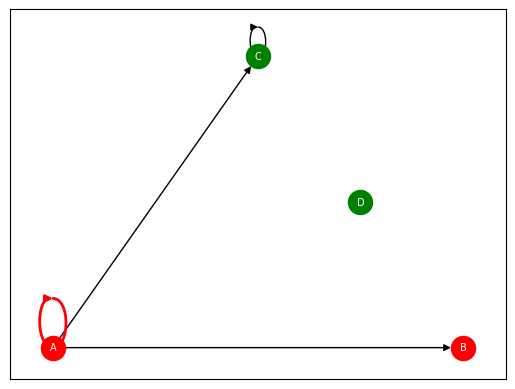

In [ ]:
# Find all pairs of nodes 1, 2 where 1 has a self loop
_assert_match(input_graph, '1->1; 2', [{'1': 'A', '2': 'B'}, {'1': 'A', '2': 'C'}, {'1': 'A', '2': 'D'}, 
                                    {'1': 'C', '2': 'A'}, {'1': 'C', '2': 'B'}, {'1': 'C', '2': 'D'}])

Plotting the match: {'1': 'A', '2': 'B'}


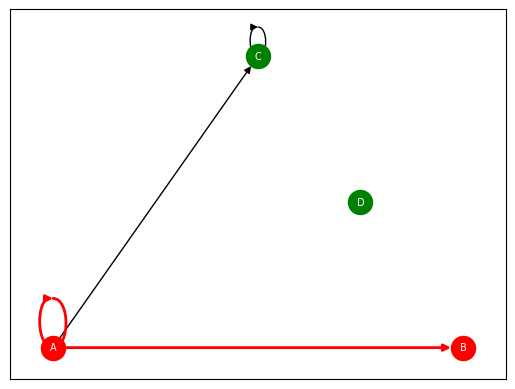

In [ ]:
_assert_match(input_graph, '1->1; 1->2', [{'1': 'A', '2': 'B'}, {'1': 'A', '2': 'C'}])

Plotting the match: {'2': 'A', '1': 'C'}


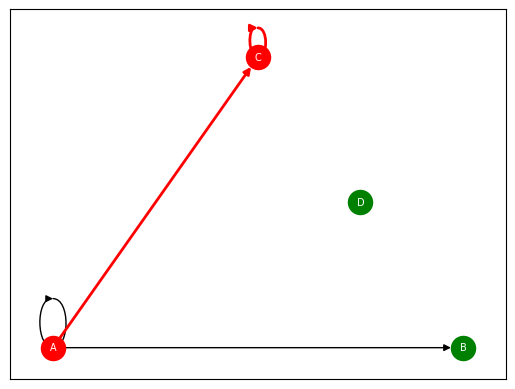

In [ ]:
_assert_match(input_graph, '1->1; 2->1', [{'1': 'C', '2': 'A'}])

In [ ]:
# Find a circle in the graph + self loop. There is no such match in the graph
_assert_match(input_graph, '1->1; 2->1->2', [])

In [ ]:
# Find five different nodes (the different pattern names enforce it).
# There are only 4 nodes in the input graph, and so there are no matches.
_assert_match(input_graph, '1;2;3;4;5', [])

#### Advanced Test Cases

Now, we want to check more advanced features of both the parser and the matcher:
* Checking for attributes (existance only)
* Checking for attributes (match the values as well, using the parser-generated condition function)
* Add user conditions
* Anonymous nodes

We will work with a new input graph, which shows the connections between students and the courses they took throughout their degree:
* Each node in the graph is associated with either a student or a course (and has an attribute "type" to denote which is which).
* A student is defined by his/her name. Some students (not all of them) also metion their faculty.
* A course is defined by its name. Some courses mention their associated number of units.
* An edge from a student to a course denotes that the student took the course. It mentions the semester in which the student took the course.
* An edge from a course to another course denotes that the first must be taken before the latter.

The graph looks like this:

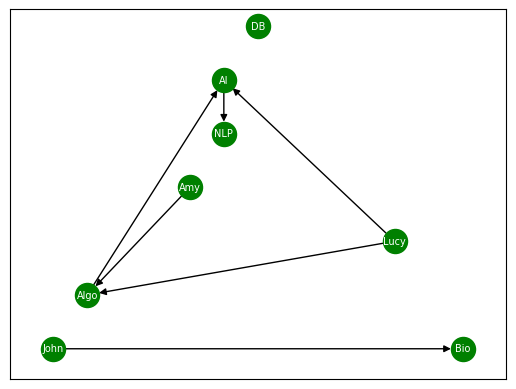

In [ ]:
input_graph = _create_graph(
    [
        # Names
        ('John', {'type': 'student', 'faculty': 'Biology'}),
        ('Lucy', {'type': 'student', 'fauclty': 'CS'}),
        ('Amy', {'type': 'student'}),
        # Courses
        ('Algo', {'type': 'course', 'units': 3}),
        ('AI', {'type': 'course', 'units': 3}),
        ('NLP', {'type': 'course', 'units': 5}),
        ('DB', {'type': 'course'}),
        ('Bio', {'type': 'course'})
    ], 
    [
        # Students take
        ('John', 'Bio', {'sem': 3}),
        ('Lucy', 'Algo', {'sem': 5}),
        ('Lucy', 'AI', {'sem': 7}),
        ('Amy', 'Algo', {'sem': 5}),
        # KDAM
        ('Algo', 'AI'),
        ('AI', 'NLP'),
    ]
)
_plot_graph(input_graph)

We will now run some useful queries by matching patterns in the graph:

Plotting the match: {'s': 'John'}


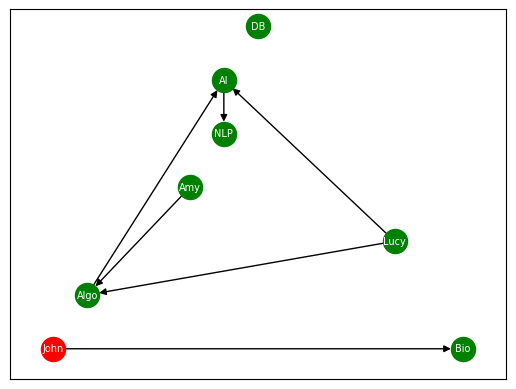

In [ ]:
# Find all students
_assert_match(input_graph, 's[type="student"]', [{'s': student} for student in ['Amy', 'John', 'Lucy']])

Plotting the match: {'c': 'Algo'}


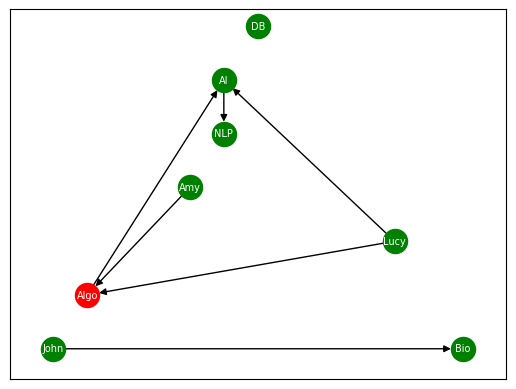

In [ ]:
# Find all courses
_assert_match(input_graph, 'c[type="course"]', [{'c': course} for course in ['DB','NLP','AI','Algo','Bio']])

Plotting the match: {'s': 'John'}


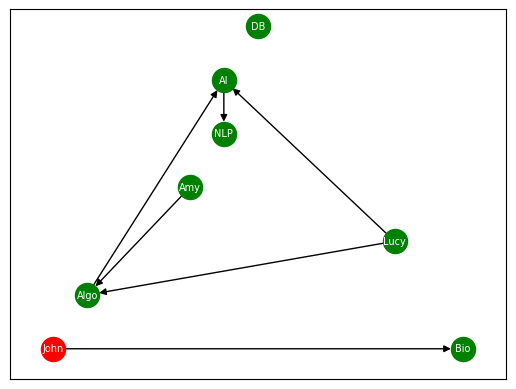

In [ ]:
# Find all students that took some course (all of them)
_assert_match(input_graph, 's[type="student"]->_[type="course"]', [{'s': 'Amy'}, {'s': 'John'}, {'s': 'Lucy'}])

Plotting the match: {'s': 'Lucy'}


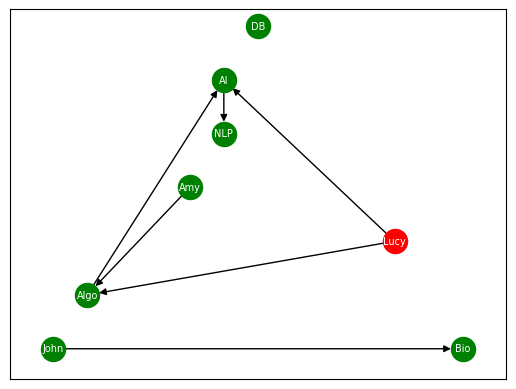

In [ ]:
# Find all students that took some 3-units course
_assert_match(input_graph, 's[type="student"]->_[type="course", units=3]', [{'s': 'Amy'}, {'s': 'Lucy'}])

Plotting the match: {'s': 'Lucy', 'c': 'Algo'}


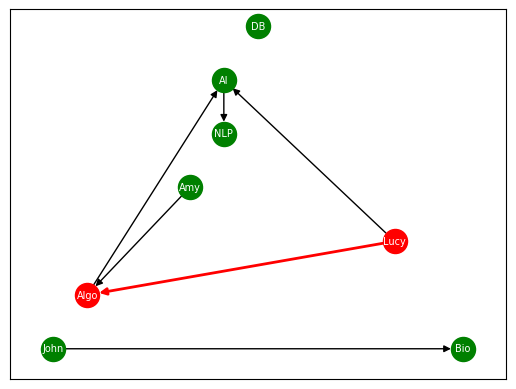

In [ ]:
# Find all students that took some 3-units course, and the associated courses
_assert_match(input_graph, 's[type="student"]->c[type="course", units=3]', [
    {'s': 'Amy', 'c': 'Algo'}, {'s': 'Lucy', 'c': 'Algo'}, {'s': 'Lucy', 'c': 'AI'}
])

Plotting the match: {'s': 'Lucy', 'c2': 'AI', 'c1': 'Algo'}


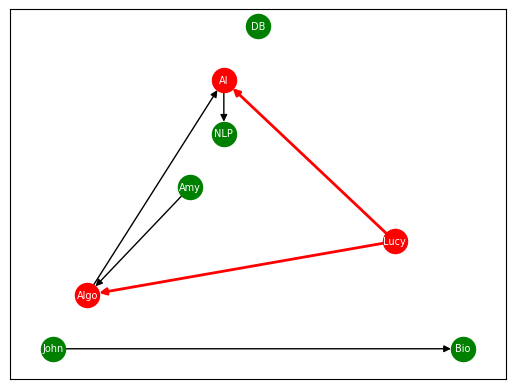

In [ ]:
# Find all students which took two courses (and the courses)
_assert_match(input_graph, 's[type="student"]->c1[type="course"]; s->c2[type="course"]', [
    {'s': 'Lucy', 'c1': 'AI', 'c2': 'Algo'},
    {'s': 'Lucy', 'c1': 'Algo', 'c2': 'AI'}
])

Plotting the match: {'c2': 'AI', 'c3': 'NLP', 'c1': 'Algo'}


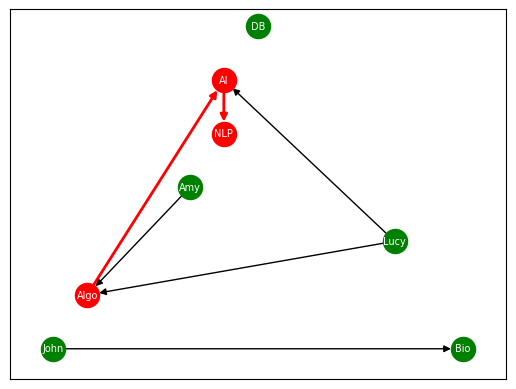

In [ ]:
# Find all tripltes c1, c2, c3 of courses such that c1 is a prerequisite of c2, and the same for c2 and c3
_assert_match(input_graph, 'c1[type="course"]->c2[type="course"]->c3[type="course"]', [
    {'c1': 'Algo', 'c2': 'AI', 'c3': 'NLP'}
])

Plotting the match: {'s': 'Lucy'}


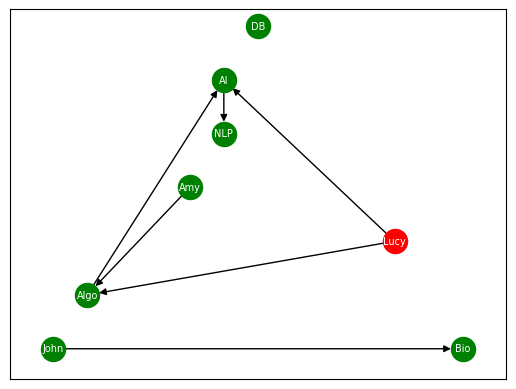

In [ ]:
# Find all students that took a course in their 7th semester
_assert_match(input_graph, 's[type="student"]-[sem=7]->_[type="course"]', [
    {'s': 'Lucy'}
])

Plotting the match: {'c': 'Bio', 's': 'John'}


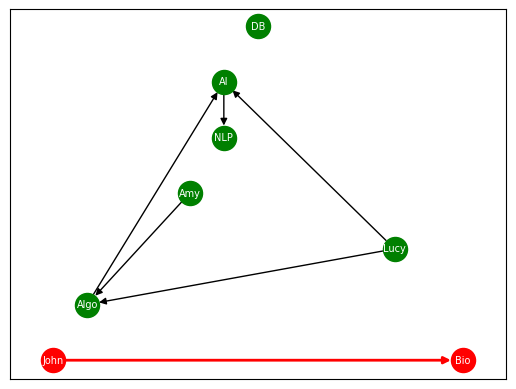

In [ ]:
# Find all students that took a course before their 5th semester (use user-defined condition)
_assert_match(input_graph, 's[type="student"]-[sem]->c[type="course"]', [
    {'s': 'John', 'c': 'Bio'}
], condition=lambda match: match['s->c']['sem'] < 5)

#### POC For Large Graphs

In [ ]:
# POC: High number of nodes, solved with attribute filtering
num_nodes = 100000

input_graph = _create_graph(
    [n for n in range(num_nodes)] + [(num_nodes+1, {'attr': 15}), (num_nodes+2, {'attr': 15})], 
    [
        (num_nodes+1, num_nodes+2),
        (2,4),
        (3,1)
    ]
)

_assert_match(input_graph, 'X[attr]->Y[attr]', [{'X': num_nodes+1, 'Y': num_nodes+2}], plot=False)